In [109]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext nb_black
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from skimage.measure import compare_psnr, compare_ssim
import cnnbin
from cnnbin.utils import psnr
from cnnbin.utils import clipto8bit

from skimage.color import rgb2gray
from skimage.measure import compare_psnr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [ ]:
import ncxtutils

stfile = "Y:/2020Data/Zehr/symbiont/Zehr_symbiont_fixed_cells_2/IMOD/Zehr_symbiont_fixed_cells_2_8/Zehr_symbiont_fixed_cells_2_8.st"
st = ncxtutils.io.load(stfile)

In [149]:
print(crop.min(), crop.max())

0.05348822 0.089579195


<IPython.core.display.Javascript object>

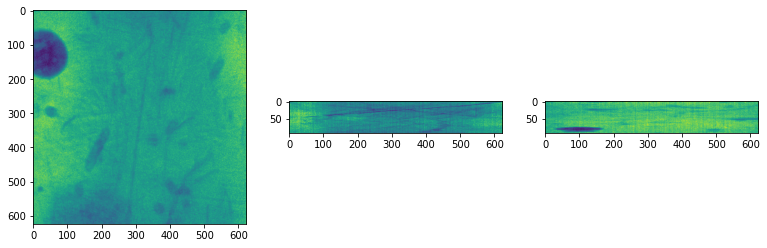

<IPython.core.display.Javascript object>

In [166]:
pad = 200
crop = st[:, pad:-pad, pad:-pad]
ncxtutils.volshow(crop)

In [170]:
for im in crop[::10]:
    a, b = cnnbin.split_diagonal(1000 * im)
    print("self", compare_psnr(a, b, (a.max() - a.min())))


self 27.780134675579298
self 27.964931025325367
self 28.15988121555673
self 27.54707734036758
self 28.17341980422146
self 27.850633037459588
self 28.433014900206253
self 29.159125656299576
self 28.233738546505876
self 28.199489493517675


<IPython.core.display.Javascript object>

self 25.751303674878923
sigma 0.04 33.97489699390442
self 27.03976300131837
sigma 0.04 34.04390589356153
self 24.4630825113962
sigma 0.04 34.01205782684213


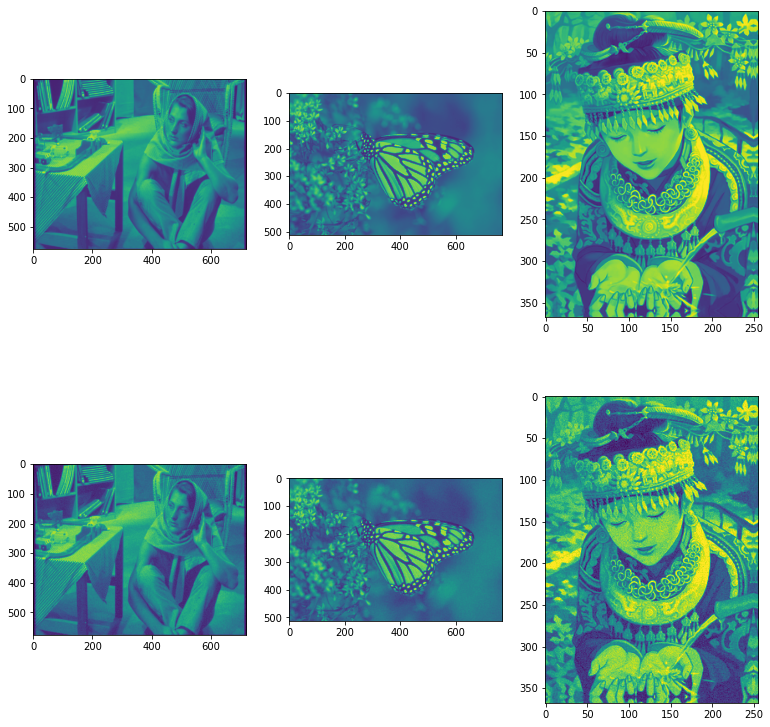

<IPython.core.display.Javascript object>

In [191]:
images_ref = [
    cnnbin.utils.pad2bin(rgb2gray(imageio.imread(x)))
    for x in ["data/barbara.bmp", "data/monarch.bmp", "data/comic.bmp"]
]


sigmas = [0.04]
images = []
references = []
baseline = []
for sigma in sigmas:
    for x in images_ref:
        noisy = x + sigma * np.random.standard_normal(x.shape)
        a, b = cnnbin.split_diagonal(noisy)
        print("self", compare_psnr(a, b, 1))
        images.append(noisy)
        references.append(np.mean(cnnbin.split_diagonal(x), 0))
        baseline.append(np.mean(cnnbin.split_diagonal(noisy), 0))
        print("sigma", sigma, compare_psnr(references[-1], baseline[-1], 1))

f, ax = plt.subplots(ncols=len(images_ref), nrows=len(sigmas) + 1, figsize=(13, 13))
for ax, im in zip(ax.ravel(), images_ref + images):
    ax.imshow(im, clim=(0, 1))

default -31.551233495776625


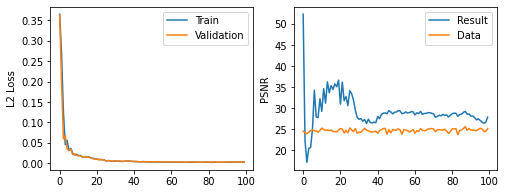

<IPython.core.display.Javascript object>

In [192]:
from tqdm.notebook import tqdm
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args


class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()


def train_net(depth=3, start_filts=48, lr1=5e-4, alpha=0.95):
    block_size = (128, 128)
    net = cnnbin.CNNbin(
        multichannel=False, depth=depth, start_filts=start_filts, block_size=block_size
    )
    net.train_list(images, num_epochs=100, samples=2, learning_rate=lr1, alpha=alpha)
    return net


net = train_net()
filtered_images = [net.filter(image).astype("double") for image in images]
scores = [compare_psnr(ref, im, 1) for ref, im in zip(references, filtered_images)]
print(f"default {-np.mean(scores)}")
net.plot_train()

In [197]:
# https://xgboost.readthedocs.io/en/latest/parameter.html

space = [
    Integer(4, 64, name="start_filts"),
    Integer(2, 4, name="depth"),
    #     Real(10 ** -6, 10 ** -3, "log-uniform", name="lr1"),
    #     Real(10 ** -6, 10 ** -3, "log-uniform", name="lr2"),
    Real(0.5, 1, name="alpha"),
]


@use_named_args(space)
def objective(**params):
    #     print(params)
    net = train_net(**params)
    filtered_images = [net.filter(image).astype("double") for image in images]
    scores = [compare_psnr(ref, im, 1) for ref, im in zip(references, filtered_images)]
    #     print(scores)

    return -np.mean(scores)


n_calls = 20
res_gp = gp_minimize(
    objective,
    space,
    n_calls=n_calls,
    random_state=0,
    callback=[tqdm_skopt(total=n_calls, desc="HyperParameter")],
)

C:\Users\axela\Documents\GitHub\ncxt_cnnbin\cnnbin\utils.py:213: RuntimeWarning: divide by zero encountered in true_divide
  return 20 * np.log10(psnr_range / np.sqrt(mean_squared_error))


<IPython.core.display.Javascript object>

[22, 2, 0.6363281472900566]


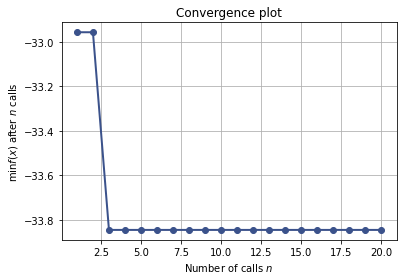

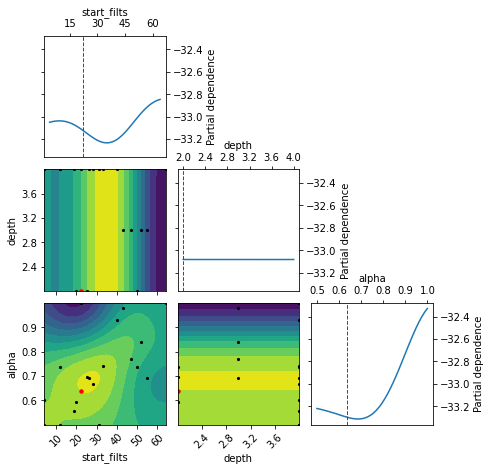

<IPython.core.display.Javascript object>

In [198]:
from skopt.plots import plot_convergence, plot_objective
print(res_gp.x)
parlist=["start_filts","depth","alpha"]
_ =plot_convergence(res_gp)
_ =plot_objective(res_gp,dimensions = parlist)


{'start_filts': 22, 'depth': 2, 'alpha': 0.6363281472900566}


Score -33.34883278725524
Base -34.010286904769366


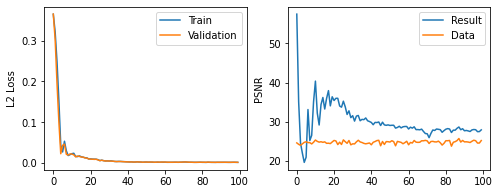

[33.755529016494606, 34.56831693946655, 31.722652405804546]


<IPython.core.display.Javascript object>

In [199]:
pardict = dict(zip(parlist, res_gp.x))
print(pardict)
net = train_net(**pardict)
filtered_images = [net.filter(image).astype("double") for image in images]
scores = [compare_psnr(ref, im, 1) for ref, im in zip(references, filtered_images)]
scores_b = [compare_psnr(ref, im, 1) for ref, im in zip(references, baseline)]

print(f"Score {-np.mean(scores)}")
print(f"Base {-np.mean(scores_b)}")

net.plot_train()
print(scores)

In [ ]:
filtered_images = [net.filter(image).astype("double") for image in images]

f, ax = plt.subplots(ncols=len(images_ref), nrows=len(sigmas) + 1, figsize=(13, 13))
for ax, im in zip(ax.ravel(), images_ref + filtered_images):
    ax.imshow(im, clim=(0, 1))